# Memory and execution time analysis 

In [1]:
import json
import pandas as pd
import statistics as stats
import re
import pprint
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
ALL_TABULAR_DATASETS = ["adult", "census", "child", "covtype", "credit", "insurance", "health_insurance", 
                       "intrusion", "drugs", "loan", "pums"]
ALL_TABULAR_MODELS = {
    "gretel": ["actgan"], 
    "sdv": ["ctgan", "tvae", "gaussian_copula"], 
    "synthcity": ["ctgan", "tvae", "goggle", "arf", "ddpm", "nflow", "rtvae"], 
    "llm": ["great"], 
    "betterdata": ["gan", "gan_dp"],
    "hpo_synthcity": ["arf", "ctgan", "ddpm", "rtvae", "tvae"]
}

ALL_SEQUENTIAL_DATASETS = ["taxi", "nasdaq", "pums"]

ALL_SEQUENTIAL_MODELS = {
    "gretel": ["dgan"],
    "sdv": ["par"]
}

In [3]:
# Define the human-readable memory conversion function
def human_readable_memory(mb):
    if mb < 1024:
        return f"{mb} MB"
    elif mb < 1024**2:
        gb = mb / 1024
        return f"{gb:.2f} GB"
    else:
        tb = mb / (1024**2)
        return f"{tb:.2f} TB"

# Function to convert string to timedelta
def convert_to_timedelta(time_str):
    try:
        seconds = int(time_str)
        return str(timedelta(seconds=seconds))
    except ValueError:
        # Return None or an appropriate value if conversion fails
        return None


In [4]:
ERROR_VAL  = -99
def get_execution_scores_df(exp_dataset, case="tabular"):
    
    final_report = {
        "dataset": [],
        "lib": [], 
        "model": [],
        "num_rows": [], 
        "num_cols": [], 
        "num_sampled_rows": [],
        "device": [],
        "num_epochs": [], 
        "train_time_sec": [],
        "sample_time_sec": [], 
        "peak_memory_mb": [], 
        "synthesizer_size": [],
        "synthetic_dataset_size_mb_deep": [], 
        "train_dataset_size_mb_deep": [], 
        "synthetic_dataset_size_mb": [],
        "train_dataset_size_mb": []
    }
    
    for lib, models in ALL_TABULAR_MODELS.items():
        
        for model in models: 
            
            BASE = f"final_outs/{lib}_tabular"
            execution_scores_path = f"../{BASE}/{model}/{exp_dataset}/{exp_dataset}_{model}_execution_scores.json"
            
            try:
                with open(execution_scores_path, 'r') as file:
                    execution_scores = json.load(file)
            except Exception as e:
                # print(e)
                continue
                      
            # corr_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_correlation.csv"
            # metrics_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"
            final_report["model"].append(f"{model}_{lib}")
            for k, v in final_report.items():
                if k in ["model"]: continue # "modality", "synthesizer"
                
                if k not in execution_scores:
                    final_report[k].append("-99")
                    continue
                final_report[k].append(execution_scores[k])
                    
# execution_scores
    # for k, v in final_report.items():
    #     print(k, len(v))
                    
    return final_report

In [7]:
execution_scores_df = pd.DataFrame()
for exp_dataset in ALL_TABULAR_DATASETS:
    final_report = get_execution_scores_df(exp_dataset, case="tabular")
    execution_scores_df = pd.concat([execution_scores_df, pd.DataFrame(final_report)], ignore_index=True)
execution_scores_df.shape 

(110, 16)

In [39]:
execution_scores_df.to_csv("execution_scores.csv")

In [8]:
execution_scores_df["device"].unique()

array(['GPU', 'CPU', 'cpu', '-99', 'cuda'], dtype=object)

In [9]:
execution_scores_df['read_train_time'] = execution_scores_df['train_time_sec'].apply(convert_to_timedelta)
execution_scores_df['read_sample_time'] = execution_scores_df['sample_time_sec'].apply(convert_to_timedelta)
execution_scores_df['read_peak_memory'] = execution_scores_df['peak_memory_mb'].apply(human_readable_memory)
execution_scores_df['read_synthesizer_size'] = execution_scores_df['synthesizer_size'].apply(human_readable_memory)

In [10]:
execution_scores_df.shape

(110, 20)

In [11]:
def plot_bar(subset, col_name='sdv_quality_report'):
    subset = subset.sort_values(by=col_name)

    # Plotting the bar graph
    plt.figure(figsize=(10, 2))
    plt.bar(subset['model'], subset[col_name], color='blue', width=0.6)  # Create a bar graph
    plt.xlabel(col_name)  # Label for X-axis
    plt.ylabel('Values')    # Label for Y-axis
    plt.xticks(rotation=90)
    plt.title('Bar Graph of Sorted Values by Category')  # Title of the graph
    plt.show()
    return plt

### Analysis of the models 

In [12]:
sort_by_metric = "synthesizer_size"

In [13]:
subset = execution_scores_df[execution_scores_df["model"] == "arf_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
38,covtype,synthcity==0.2.9,arf_synthcity,464809,55,581012,cuda,0,45131.397371,20004.786831,20945.243966,6892.086834,260.293376,208.234432,260.293376,208.234432,12:32:11,5:33:24,20.45 GB,6.73 GB
21,census,synthcity==0.2.9,arf_synthcity,239428,41,299285,cpu,0,17353.143302,10469.360526,10426.644256,3681.623219,651.023555,519.801752,100.55976,80.447808,4:49:13,2:54:29,10.18 GB,3.60 GB
47,credit,synthcity==0.2.9,arf_synthcity,227845,30,284807,cpu,0,9503.303507,2485.023380,12287.730712,2631.409685,70.632136,56.50556,70.632136,56.50556,2:38:23,0:41:25,12.00 GB,2.57 GB
77,intrusion,synthcity==0.2.9,arf_synthcity,395216,41,494021,cpu,0,1692.388065,10478.220127,16754.339342,396.806719,270.092557,216.029772,165.991056,132.792576,0:28:12,2:54:38,16.36 GB,396.806719 MB
55,insurance,synthcity==0.2.9,arf_synthcity,16000,27,20000,cuda,0,715.619799,335.933411,741.157193,262.571478,25.837498,20.660438,3.5,2.8,0:11:55,0:05:35,741.157193 MB,262.571478 MB
7,adult,synthcity==0.2.9,arf_synthcity,26048,15,32561,cpu,0,1358.923872,210.333355,676.607016,243.196847,21.09892,16.886184,4.167808,3.334144,0:22:38,0:03:30,676.607016 MB,243.196847 MB
30,child,synthcity==0.2.9,arf_synthcity,16000,20,20000,cuda,0,384.656190,232.092816,534.455349,187.803084,24.865105,19.891202,3.36,2.688,0:06:24,0:03:52,534.455349 MB,187.803084 MB
85,drugs,synthcity==0.2.9,arf_synthcity,6107,39,7634,cuda,0,628.581176,202.347365,384.917149,110.356191,17.975886,14.296115,2.44288,1.95424,0:10:28,0:03:22,384.917149 MB,110.356191 MB
96,loan,synthcity==0.2.9,arf_synthcity,4000,14,5000,cpu,0,219.610870,36.644718,188.404349,44.731028,0.6,0.48,0.6,0.48,0:03:39,0:00:36,188.404349 MB,44.731028 MB
66,health_insurance,synthcity==0.2.9,arf_synthcity,1070,7,1338,cpu,0,8.339499,10.925338,83.110320,6.425509,0.303951,0.24308,0.085632,0.06848,0:00:08,0:00:10,83.11032 MB,6.425509 MB


In [14]:
subset = execution_scores_df[execution_scores_df["model"] == "ddpm_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
39,covtype,synthcity==0.2.9,ddpm_synthcity,464809,55,581012,cuda,5000,118270.378157,10839.105222,2116.727556,109.720301,260.293376,208.234432,260.293376,208.234432,"1 day, 8:51:10",3:00:39,2.07 GB,109.720301 MB
22,census,synthcity==0.2.9,ddpm_synthcity,239428,41,299285,cpu,5000,173360.587952,42572.829726,832.510068,45.317454,646.103078,519.801752,100.55976,80.447808,"2 days, 0:09:20",11:49:32,832.510068 MB,45.317454 MB
8,adult,synthcity==0.2.9,ddpm_synthcity,26048,15,32561,cpu,5000,6473.861951,578.001732,99.675241,6.281305,21.099001,16.886184,4.167808,3.334144,1:47:53,0:09:38,99.675241 MB,6.281305 MB
56,insurance,synthcity==0.2.9,ddpm_synthcity,16000,27,20000,cuda,5000,3152.624346,247.556716,96.438931,5.678757,25.838141,20.660438,3.5,2.8,0:52:32,0:04:07,96.438931 MB,5.678757 MB
86,drugs,synthcity==0.2.9,ddpm_synthcity,6107,39,7634,cuda,5000,1350.116638,110.943826,84.787394,5.055033,17.872297,14.296115,2.44288,1.95424,0:22:30,0:01:50,84.787394 MB,5.055033 MB
31,child,synthcity==0.2.9,ddpm_synthcity,16000,20,20000,cuda,5000,2843.874894,205.397614,88.288377,5.043989,24.864581,19.891202,3.36,2.688,0:47:23,0:03:25,88.288377 MB,5.043989 MB
97,loan,synthcity==0.2.9,ddpm_synthcity,4000,14,5000,cpu,5000,943.583055,90.133452,72.263348,3.947958,0.6,0.48,0.6,0.48,0:15:43,0:01:30,72.263348 MB,3.947958 MB
67,health_insurance,synthcity==0.2.9,ddpm_synthcity,1070,7,1338,cpu,5000,284.138159,16.615418,68.001337,3.513178,0.30385,0.24308,0.085632,0.06848,0:04:44,0:00:16,68.001337 MB,3.513178 MB


In [15]:
subset = execution_scores_df[execution_scores_df["model"] == "rtvae_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
40,covtype,synthcity==0.2.9,rtvae_synthcity,464809,55,581012,cuda,300,44889.613309,99.416461,3109.798841,919.328901,260.293376,208.234432,260.293376,208.234432,12:28:09,0:01:39,3.04 GB,919.328901 MB
48,credit,synthcity==0.2.9,rtvae_synthcity,227845,30,284807,cpu,300,91379.894162,644.339354,1897.840788,171.064624,70.632136,56.50556,70.632136,56.50556,"1 day, 1:22:59",0:10:44,1.85 GB,171.064624 MB
58,insurance,synthcity==0.2.9,rtvae_synthcity,16000,27,20000,cuda,300,1018.903471,1.969418,124.471521,57.506470,25.830838,20.660438,3.5,2.8,0:16:58,0:00:01,124.471521 MB,57.50647 MB
33,child,synthcity==0.2.9,rtvae_synthcity,16000,20,20000,cuda,300,762.032615,1.593081,106.565976,47.219337,24.858097,19.891202,3.36,2.688,0:12:42,0:00:01,106.565976 MB,47.219337 MB
10,adult,synthcity==0.2.9,rtvae_synthcity,26048,15,32561,cpu,300,4107.705225,11.591618,161.626765,44.557675,21.181972,16.886184,4.167808,3.334144,1:08:27,0:00:11,161.626765 MB,44.557675 MB
88,drugs,synthcity==0.2.9,rtvae_synthcity,6107,39,7634,cuda,300,544.553291,1.501873,100.297019,39.736204,17.912773,14.296115,2.44288,1.95424,0:09:04,0:00:01,100.297019 MB,39.736204 MB
99,loan,synthcity==0.2.9,rtvae_synthcity,4000,14,5000,cpu,300,802.399064,3.425200,77.833557,29.200426,0.6,0.48,0.6,0.48,0:13:22,0:00:03,77.833557 MB,29.200426 MB
69,health_insurance,synthcity==0.2.9,rtvae_synthcity,1070,7,1338,cpu,300,103.123930,0.332816,68.651949,26.911021,0.303928,0.24308,0.085632,0.06848,0:01:43,0:00:00,68.651949 MB,26.911021 MB


In [16]:
subset = execution_scores_df[execution_scores_df["model"] == "tvae_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
76,intrusion,synthcity==0.2.9,tvae_synthcity,395216,41,494021,cuda,300,29892.119398,63.209620,2580.030017,586.659151,270.400417,216.029772,165.991056,132.792576,8:18:12,0:01:03,2.52 GB,586.659151 MB
46,credit,synthcity==0.2.9,tvae_synthcity,227845,30,284807,cpu,300,40325.780874,54.298643,1897.842318,171.064619,70.632136,56.50556,70.632136,56.50556,11:12:05,0:00:54,1.85 GB,171.064619 MB
53,insurance,synthcity==0.2.9,tvae_synthcity,16000,27,20000,cpu,300,4288.600060,4.651339,124.461128,57.506387,25.835544,20.660438,3.5,2.8,1:11:28,0:00:04,124.461128 MB,57.506387 MB
28,child,synthcity==0.2.9,tvae_synthcity,16000,20,20000,cpu,300,1834.748078,3.120516,106.624319,47.219270,24.860812,19.891202,3.36,2.688,0:30:34,0:00:03,106.624319 MB,47.21927 MB
5,adult,synthcity==0.2.9,tvae_synthcity,26048,15,32561,cpu,300,2839.433315,2.598833,161.627016,44.557670,21.110107,16.886184,4.167808,3.334144,0:47:19,0:00:02,161.627016 MB,44.55767 MB
83,drugs,synthcity==0.2.9,tvae_synthcity,6107,39,7634,cpu,300,1656.401611,1.938672,100.297189,39.736115,17.886365,14.296115,2.44288,1.95424,0:27:36,0:00:01,100.297189 MB,39.736115 MB
94,loan,synthcity==0.2.9,tvae_synthcity,4000,14,5000,cpu,300,643.590710,0.690099,77.835147,29.200421,0.6,0.48,0.6,0.48,0:10:43,0:00:00,77.835147 MB,29.200421 MB
64,health_insurance,synthcity==0.2.9,tvae_synthcity,1070,7,1338,cpu,300,94.221954,0.164197,68.652287,26.911016,0.304001,0.24308,0.085632,0.06848,0:01:34,0:00:00,68.652287 MB,26.911016 MB


In [17]:
subset = execution_scores_df[execution_scores_df["model"] == "ctgan_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
75,intrusion,synthcity==0.2.9,ctgan_synthcity,395216,41,494021,cuda,300,34805.180968,15.743593,2580.019124,581.768791,270.188552,216.029772,165.991056,132.792576,9:40:05,0:00:15,2.52 GB,581.768791 MB
45,credit,synthcity==0.2.9,ctgan_synthcity,227845,30,284807,cpu,300,89626.668572,140.276466,1897.861075,167.599348,70.632136,56.50556,70.632136,56.50556,"1 day, 0:53:46",0:02:20,1.85 GB,167.599348 MB
52,insurance,synthcity==0.2.9,ctgan_synthcity,16000,27,20000,cpu,300,1805.528209,1.436538,123.965995,50.884597,25.845193,20.660438,3.5,2.8,0:30:05,0:00:01,123.965995 MB,50.884597 MB
27,child,synthcity==0.2.9,ctgan_synthcity,16000,20,20000,cpu,300,1396.669868,1.027637,106.187624,40.481244,24.868986,19.891202,3.36,2.688,0:23:16,0:00:01,106.187624 MB,40.481244 MB
4,adult,synthcity==0.2.9,ctgan_synthcity,26048,15,32561,cpu,300,5387.746336,9.032208,161.648593,38.916708,21.105475,16.886184,4.167808,3.334144,1:29:47,0:00:09,161.648593 MB,38.916708 MB
82,drugs,synthcity==0.2.9,ctgan_synthcity,6107,39,7634,cpu,300,1573.181549,3.000246,100.286097,34.401091,17.913235,14.296115,2.44288,1.95424,0:26:13,0:00:03,100.286097 MB,34.401091 MB
93,loan,synthcity==0.2.9,ctgan_synthcity,4000,14,5000,cpu,300,530.132238,0.398153,77.857009,23.225087,0.6,0.48,0.6,0.48,0:08:50,0:00:00,77.857009 MB,23.225087 MB
63,health_insurance,synthcity==0.2.9,ctgan_synthcity,1070,7,1338,cpu,300,92.086848,0.124527,68.813642,20.388536,0.303692,0.24308,0.085632,0.06848,0:01:32,0:00:00,68.813642 MB,20.388536 MB


In [18]:
subset = execution_scores_df[execution_scores_df["model"] == "goggle_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
84,drugs,synthcity==0.2.9,goggle_synthcity,6107,39,7634,cpu,300,2117.021192,22.239583,97.140948,9.360272,17.903522,14.296115,2.44288,1.95424,0:35:17,0:00:22,97.140948 MB,9.360272 MB
6,adult,synthcity==0.2.9,goggle_synthcity,26048,16,32561,cpu,300,8627.379760,25.419581,161.497508,8.131883,21.260577,17.094568,4.428296,3.542528,2:23:47,0:00:25,161.497508 MB,8.131883 MB
95,loan,synthcity==0.2.9,goggle_synthcity,4000,14,5000,cpu,300,1462.278378,1.918266,77.688352,3.065430,0.6,0.48,0.6,0.48,0:24:22,0:00:01,77.688352 MB,3.06543 MB
54,insurance,synthcity==0.2.9,goggle_synthcity,16000,27,20000,cpu,300,3193.426126,157.558704,105.520733,2.560964,25.671289,20.660438,3.5,2.8,0:53:13,0:02:37,105.520733 MB,2.560964 MB
29,child,synthcity==0.2.9,goggle_synthcity,16000,20,20000,cpu,300,1387.224844,215.064614,93.103152,1.277825,24.850142,19.891202,3.36,2.688,0:23:07,0:03:35,93.103152 MB,1.277825 MB
65,health_insurance,synthcity==0.2.9,goggle_synthcity,1070,7,1338,cpu,300,105.554705,0.239172,68.829702,0.918204,0.303434,0.24308,0.085632,0.06848,0:01:45,0:00:00,68.829702 MB,0.918204 MB


In [19]:
subset = execution_scores_df[execution_scores_df["model"] == "nflow_synthcity"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
87,drugs,synthcity==0.2.9,nflow_synthcity,6107,39,7634,cuda,3000,466.009283,2.954708,94.918369,3.917555,17.935962,14.296115,2.44288,1.95424,0:07:46,0:00:02,94.918369 MB,3.917555 MB
9,adult,synthcity==0.2.9,nflow_synthcity,26048,15,32561,cpu,3000,1720.564516,95.238318,151.902518,3.654027,21.152703,16.886184,4.167808,3.334144,0:28:40,0:01:35,151.902518 MB,3.654027 MB
98,loan,synthcity==0.2.9,nflow_synthcity,4000,14,5000,cpu,3000,415.900657,8.077032,76.508232,2.285433,0.6,0.48,0.6,0.48,0:06:55,0:00:08,76.508232 MB,2.285433 MB
57,insurance,synthcity==0.2.9,nflow_synthcity,16000,27,20000,cuda,3000,1595.982682,3.312545,104.234656,1.948059,25.812783,20.660438,3.5,2.8,0:26:35,0:00:03,104.234656 MB,1.948059 MB
32,child,synthcity==0.2.9,nflow_synthcity,16000,20,20000,cuda,3000,1237.550875,2.552199,92.132051,1.373340,24.855214,19.891202,3.36,2.688,0:20:37,0:00:02,92.132051 MB,1.37334 MB
68,health_insurance,synthcity==0.2.9,nflow_synthcity,1070,7,1338,cpu,3000,62.609643,0.905669,68.586280,1.185289,0.303471,0.24308,0.085632,0.06848,0:01:02,0:00:00,68.58628 MB,1.185289 MB


In [20]:
subset = execution_scores_df[execution_scores_df["model"] == "actgan_gretel"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
106,pums,GRETEL_0.20.0,actgan_gretel,828161,36,828161,GPU,300,50401.469090,198.961060,9927.379896,3308.896283,284.691334,291.35225,238.510496,245.135656,14:00:01,0:03:18,9.69 GB,3.23 GB
17,census,GRETEL_0.20.0,actgan_gretel,239428,42,239428,GPU,300,11141.097749,32.031656,3023.620889,1011.027493,519.92218,521.717176,80.447936,82.363232,3:05:41,0:00:32,2.95 GB,1011.027493 MB
34,covtype,GRETEL_0.20.0,actgan_gretel,464809,56,464809,GPU,300,25297.038848,70.221039,2838.488532,968.221238,208.23456,211.952904,208.23456,211.952904,7:01:37,0:01:10,2.77 GB,968.221238 MB
71,intrusion,GRETEL_0.20.0,actgan_gretel,395216,42,395216,GPU,300,19027.813927,63.862807,2236.919641,728.702433,216.179495,219.1915,132.792704,135.954304,5:17:07,0:01:03,2.18 GB,728.702433 MB
41,credit,GRETEL_0.20.0,actgan_gretel,227845,30,227845,GPU,300,8967.253481,22.078449,1093.606376,329.173317,54.682928,56.50556,54.682928,56.50556,2:29:27,0:00:22,1.07 GB,329.173317 MB
78,drugs,GRETEL_0.20.0,actgan_gretel,6107,40,6107,GPU,300,279.267477,2.136910,205.450428,83.327897,10.951319,10.922883,1.954368,2.003096,0:04:39,0:00:02,205.450428 MB,83.327897 MB
0,adult,GRETEL_0.20.0,actgan_gretel,26048,16,26048,GPU,300,844.420231,2.135426,112.538464,37.958943,16.898896,17.094568,3.334272,3.542528,0:14:04,0:00:02,112.538464 MB,37.958943 MB
49,insurance,GRETEL_0.20.0,actgan_gretel,16000,28,16000,GPU,300,575.169999,1.595064,45.965414,17.295643,20.675484,20.788438,2.800128,2.928,0:09:35,0:00:01,45.965414 MB,17.295643 MB
23,child,GRETEL_0.20.0,actgan_gretel,16000,21,16000,GPU,300,512.057396,1.277512,33.868446,12.529515,19.87667,20.019202,2.688128,2.816,0:08:32,0:00:01,33.868446 MB,12.529515 MB
89,loan,GRETEL_0.20.0,actgan_gretel,4000,14,4000,CPU,300,202.583661,0.571762,10.547722,3.899835,0.448128,0.48,0.448128,0.48,0:03:22,0:00:00,10.547722 MB,3.899835 MB


In [21]:
subset = execution_scores_df[execution_scores_df["model"] == "ctgan_sdv"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
107,pums,SDV_1.2.1,ctgan_sdv,828161,36,-99,GPU,300,34275.731180,190.307225,8131.216867,2639.754827,355.908334,291.35225,298.138304,245.135656,9:31:15,0:03:10,7.94 GB,2.58 GB
18,census,SDV_1.2.1,ctgan_sdv,239428,41,299285,CPU,300,38185.008448,38.364032,2861.407736,986.504407,646.948582,519.801752,98.165608,80.447808,10:36:25,0:00:38,2.79 GB,986.504407 MB
79,drugs,SDV_1.2.1,ctgan_sdv,6107,40,7634,CPU,300,63133.236859,7.662645,1482.101211,947.764680,13.947227,10.922882,2.443008,2.003096,17:32:13,0:00:07,1.45 GB,947.76468 MB
35,covtype,SDV_1.2.1,ctgan_sdv,464809,55,581012,CPU,300,34465.168423,101.741135,2795.060875,868.571270,255.645408,208.234432,255.645408,208.234432,9:34:25,0:01:41,2.73 GB,868.57127 MB
72,intrusion,SDV_1.2.1,ctgan_sdv,395216,41,494021,CPU,300,29959.334958,72.893574,2176.398364,675.488391,266.429332,216.029772,162.039016,132.792576,8:19:19,0:01:12,2.13 GB,675.488391 MB
42,credit,SDV_1.2.1,ctgan_sdv,227845,30,284807,CPU,300,11258.270308,18.948731,1035.224630,327.824054,68.353808,56.50556,68.353808,56.50556,3:07:38,0:00:18,1.01 GB,327.824054 MB
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,32561,CPU,300,1019.838562,2.317747,101.742050,35.808308,20.880857,16.886184,3.907448,3.334144,0:16:59,0:00:02,101.74205 MB,35.808308 MB
24,child,SDV_1.2.1,ctgan_sdv,16000,20,20000,CPU,300,534.051591,1.355828,29.154026,11.255035,24.530349,19.697801,3.200128,2.688,0:08:54,0:00:01,29.154026 MB,11.255035 MB
90,loan,SDV_1.2.1,ctgan_sdv,4000,14,5000,CPU,300,79.544001,0.417012,10.730754,4.088130,0.560128,0.48,0.560128,0.48,0:01:19,0:00:00,10.730754 MB,4.08813 MB
60,health_insurance,SDV_1.2.1,ctgan_sdv,1070,7,1338,CPU,300,24.414932,0.189142,2.309114,1.107998,0.293731,0.24308,0.075056,0.06848,0:00:24,0:00:00,2.309114 MB,1.107998 MB


In [22]:
subset = execution_scores_df[execution_scores_df["model"] == "tvae_sdv"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
50,insurance,SDV_1.2.1,tvae_sdv,16000,28,-99,GPU,300,772.472648,39.298687,43099.608133,67.116968,25.086384,20.111955,3.500128,2.928,0:12:52,0:00:39,42.09 GB,67.116968 MB
80,drugs,SDV_1.2.1,tvae_sdv,6107,40,7634,CPU,300,1448.471384,1.704046,1482.099156,6.298760,13.693944,10.922882,2.443008,2.003096,0:24:08,0:00:01,1.45 GB,6.29876 MB
36,covtype,SDV_1.2.1,tvae_sdv,464809,55,581012,CPU,300,18044.296977,66.110085,2795.059034,1.264884,255.645408,208.234432,255.645408,208.234432,5:00:44,0:01:06,2.73 GB,1.264884 MB
108,pums,SDV_1.2.1,tvae_sdv,828161,36,-99,GPU,300,22887.041172,153.788952,8131.214587,0.997506,355.923838,291.35225,298.138304,245.135656,6:21:27,0:02:33,7.94 GB,0.997506 MB
73,intrusion,SDV_1.2.1,tvae_sdv,395216,41,494021,CPU,300,15690.425063,45.278868,2114.062651,0.958695,266.203013,216.029772,162.039016,132.792576,4:21:30,0:00:45,2.06 GB,0.958695 MB
19,census,SDV_1.2.1,tvae_sdv,239428,41,299285,CPU,300,9733.092632,17.885139,2861.405798,0.882039,647.103834,519.801752,98.165608,80.447808,2:42:13,0:00:17,2.79 GB,0.882039 MB
43,credit,SDV_1.2.1,tvae_sdv,227845,30,284807,CPU,300,6718.186250,14.759176,1035.222836,0.777257,68.353808,56.50556,68.353808,56.50556,1:51:58,0:00:14,1.01 GB,0.777257 MB
91,loan,SDV_1.2.1,tvae_sdv,4000,14,5000,CPU,300,55.181274,0.391493,10.728637,0.447071,0.560128,0.48,0.560128,0.48,0:00:55,0:00:00,10.728637 MB,0.447071 MB
2,adult,SDV_1.2.1,tvae_sdv,26048,15,32561,CPU,300,378.850136,0.980367,101.740078,0.417060,20.859236,16.886184,3.907448,3.334144,0:06:18,0:00:00,101.740078 MB,0.41706 MB
25,child,SDV_1.2.1,tvae_sdv,16000,20,20000,CPU,300,175.259520,0.469466,26.281417,0.344470,24.478376,19.697801,3.200128,2.688,0:02:55,0:00:00,26.281417 MB,0.34447 MB


In [23]:
subset = execution_scores_df[execution_scores_df["model"] == "gaussian_copula_sdv"]
subset = subset.sort_values(by=sort_by_metric, ascending=False)
subset

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb,read_train_time,read_sample_time,read_peak_memory,read_synthesizer_size
81,drugs,SDV_1.2.1,gaussian_copula_sdv,6107,40,7634,CPU,0,13.805467,1.531657,22.054215,0.568552,14.258218,10.922882,2.443008,2.003096,0:00:13,0:00:01,22.054215 MB,0.568552 MB
37,covtype,SDV_1.2.1,gaussian_copula_sdv,464809,55,581012,CPU,0,310.044991,109.320973,2097.452491,0.501653,255.645408,208.234432,255.645408,208.234432,0:05:10,0:01:49,2.05 GB,0.501653 MB
20,census,SDV_1.2.1,gaussian_copula_sdv,239428,41,299285,CPU,0,197.487867,42.886971,805.920771,0.370677,646.907304,519.801752,98.165608,80.447808,0:03:17,0:00:42,805.920771 MB,0.370677 MB
74,intrusion,SDV_1.2.1,gaussian_copula_sdv,395216,41,494021,CPU,0,186.309758,58.784461,1329.700543,0.367797,266.321682,216.029772,162.039016,132.792576,0:03:06,0:00:58,1.30 GB,0.367797 MB
109,pums,SDV_1.2.1,gaussian_copula_sdv,828161,36,-99,CPU,0,691.980786,163.582960,2445.597733,0.322649,355.926141,291.35225,298.138304,245.135656,0:11:31,0:02:43,2.39 GB,0.322649 MB
44,credit,SDV_1.2.1,gaussian_copula_sdv,227845,30,284807,CPU,0,182.944455,24.842726,561.199190,0.266357,68.353808,56.50556,68.353808,56.50556,0:03:02,0:00:24,561.19919 MB,0.266357 MB
51,insurance,SDV_1.2.1,gaussian_copula_sdv,16000,27,20000,CPU,0,13.465812,1.734172,36.173790,0.235393,24.990921,19.983955,3.340128,2.8,0:00:13,0:00:01,36.17379 MB,0.235393 MB
26,child,SDV_1.2.1,gaussian_copula_sdv,16000,20,20000,CPU,0,9.832734,1.304760,26.872717,0.175013,24.310805,19.697801,3.200128,2.688,0:00:09,0:00:01,26.872717 MB,0.175013 MB
3,adult,SDV_1.2.1,gaussian_copula_sdv,26048,15,32561,CPU,0,11.544246,1.632146,32.554806,0.135811,20.769536,16.886184,3.907448,3.334144,0:00:11,0:00:01,32.554806 MB,0.135811 MB
92,loan,SDV_1.2.1,gaussian_copula_sdv,4000,14,5000,CPU,0,3.711303,0.379837,5.018223,0.126137,0.560128,0.48,0.560128,0.48,0:00:03,0:00:00,5.018223 MB,0.126137 MB


In [24]:
def plot_line_graph(df, dataset_name):    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot time in seconds on the left y-axis
    ax1.plot(df['model'], df['train_time_sec'], marker='o', color='b', linestyle='-', label='Time')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Time', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    # Set the custom tick labels for the left y-axis, make them horizontal
    ax1.set_yticks(df['train_time_sec'])
    ax1.set_yticklabels(df['read_train_time'].astype(str))  # rotation is 0 by default, which is horizontal

    # Set x-ticks to align with the 'model' column of the DataFrame
    ax1.set_xticks(range(len(df['model'])))
    ax1.set_xticklabels(df['model'], rotation=90)
    
    # Create a second y-axis for memory usage
    ax2 = ax1.twinx()
    ax2.plot(df['model'], df['peak_memory_mb'], marker='o', color='g', linestyle='-', label='Memory Usage')
    ax2.set_ylabel('Memory Usage', color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    # Set the custom tick labels for the right y-axis, make them horizontal
    ax2.set_yticks(df['peak_memory_mb'])
    ax2.set_yticklabels(df['read_peak_memory'].astype(str))  # rotation is 0 by default, which is horizontal

    # Title and legend
    plt.title(f'Dataset: {dataset_name}')
    fig.tight_layout()  # Adjust the layout to prevent clipping of ylabel

    # Place the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.1, 1))

    plt.show()

### Dataset-level analysis

In [25]:
property = "train_time_sec" # synthesizer_size, peak_memory_mb, sample_time_sec, train_time_sec

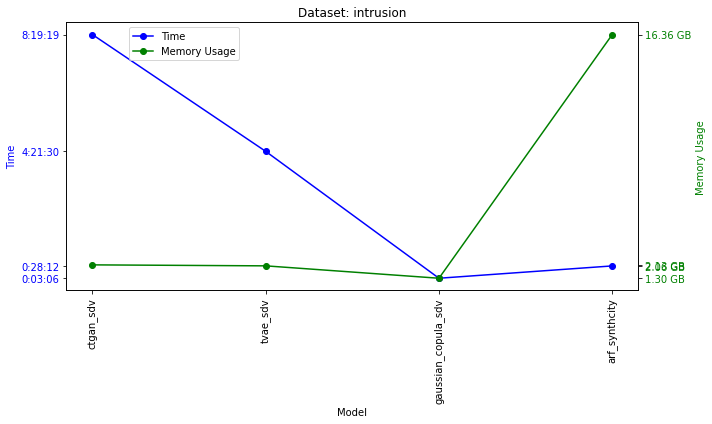

In [54]:
dataset = "intrusion"

device = ["cpu", "CPU", -99] 
# device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

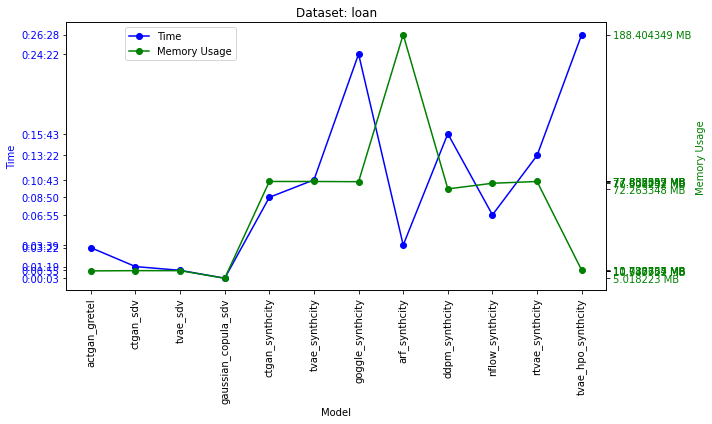

In [52]:
dataset = "loan"

device = ["cpu", "CPU", -99] 
# device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

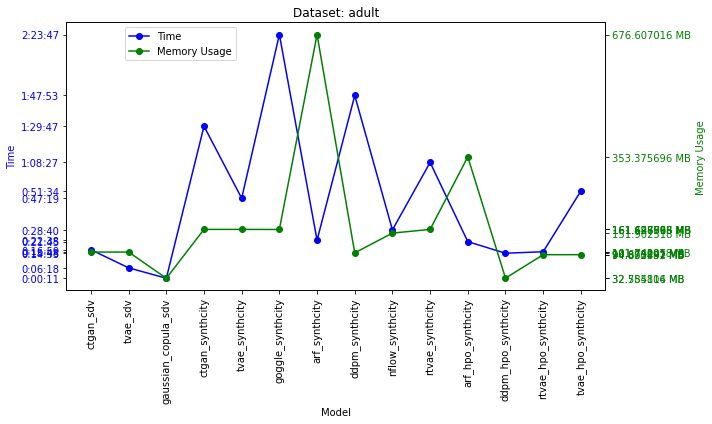

In [28]:
dataset = "adult"

device = ["cpu", "CPU", -99] 
# device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

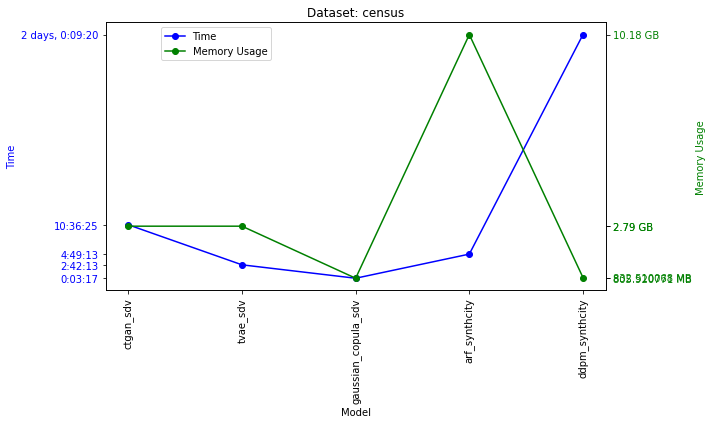

In [50]:
dataset = "census"

device = ["cpu", "CPU", -99] 
# device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

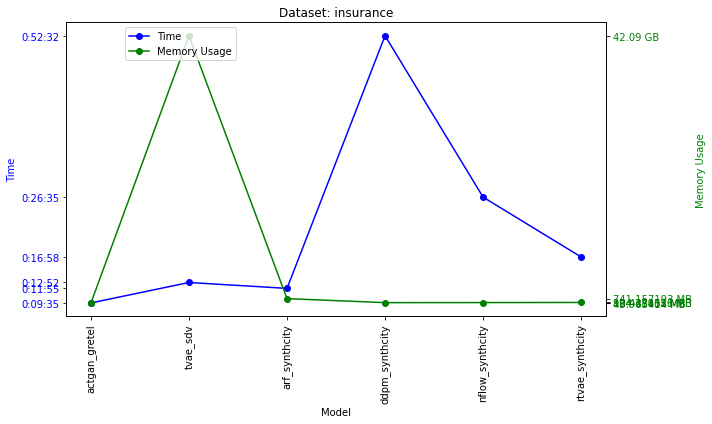

In [48]:
dataset = "insurance"
# device = ["cpu", "CPU", -99] 
device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

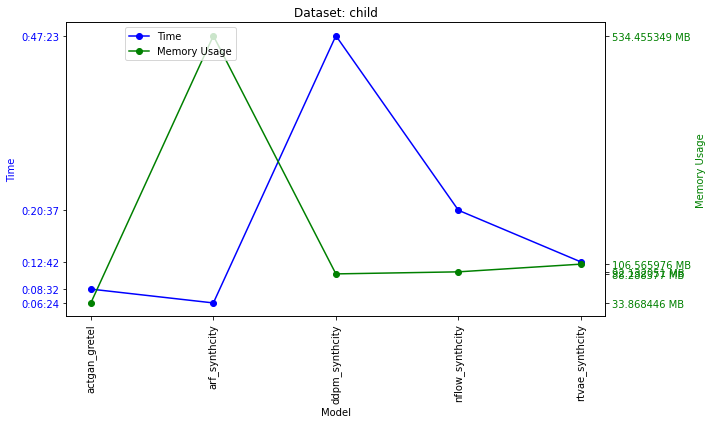

In [47]:
dataset = "child"
device = ["cpu", "CPU", -99] 
device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

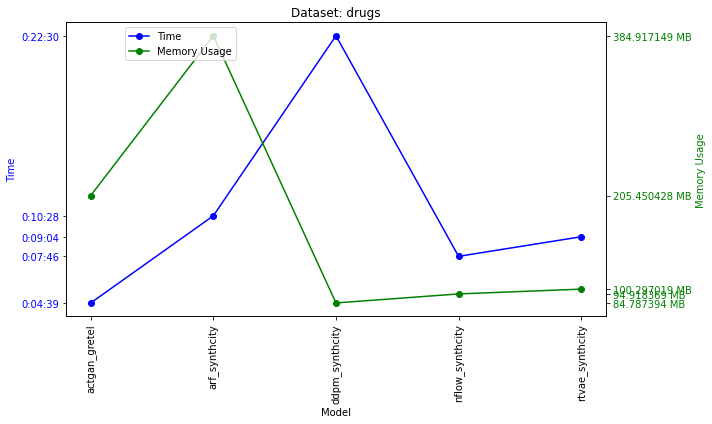

In [46]:
dataset = "drugs"
# device = ["cpu", "CPU", -99] 
device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

In [33]:
# dataset = "pums"
# device = ["cpu", "CPU", -99] 
# # device = ["cuda", "GPU"]
# subset = execution_scores_df.copy()
# subset = subset[(subset["dataset"] == dataset)]
# subset = subset[subset["device"].isin(device)]

# plot_line_graph(subset, dataset)

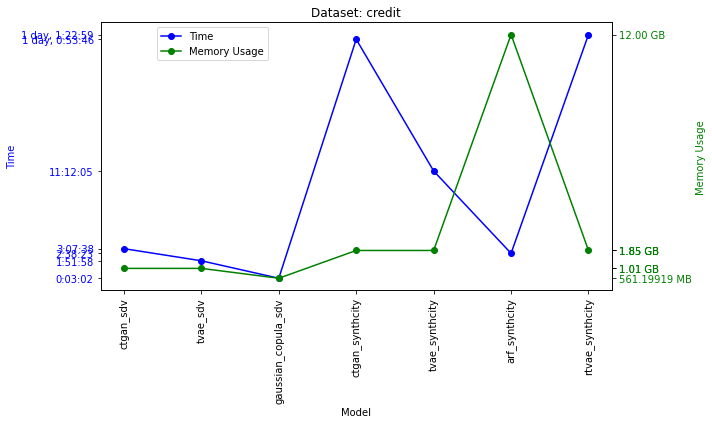

In [45]:
dataset = "credit"
device = ["cpu", "CPU", -99] 
# device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

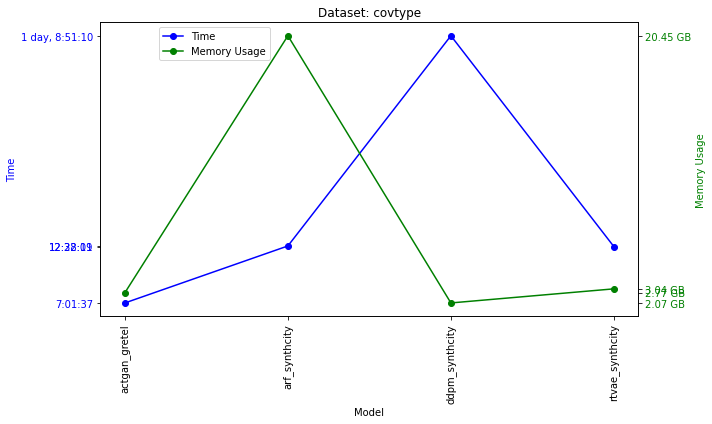

In [42]:
dataset = "covtype"
# device = ["cpu", "CPU", -99] 
device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

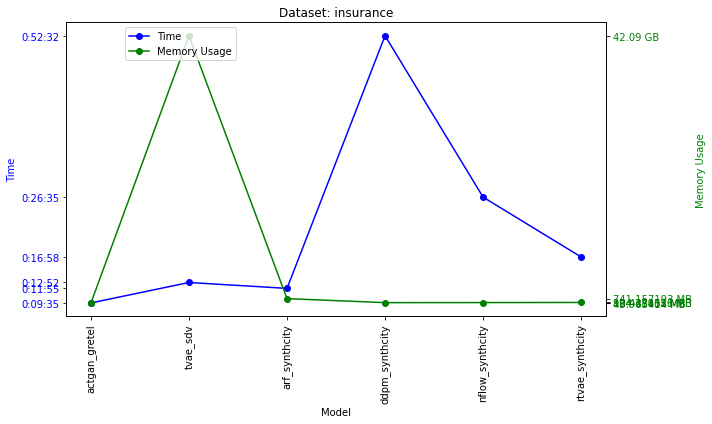

In [43]:
dataset = "insurance"
#device = ["cpu", "CPU", -99] 
device = ["cuda", "GPU"]
subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

In [37]:
execution_scores_df[execution_scores_df["device"].isin(["cuda", "GPU"])].shape

(35, 20)

In [38]:
execution_scores_df[execution_scores_df["device"].isin(["cpu", "CPU", -99])].shape

(73, 20)

In [451]:
# subset.set_index('model', inplace=True)

# # Plotting the four line graphs in one plot with different colors
# plt.figure(figsize=(12, 20))
# plt.plot(subset.index, subset['train_time_sec'], label='Train Time (sec)', color='red')
# plt.plot(subset.index, subset['sample_time_sec'], label='Sample Time (sec)', color='green')
# plt.plot(subset.index, subset['peak_memory_mb'], label='Peak Memory (MB)', color='blue')
# plt.plot(subset.index, subset['synthesizer_size'], label='Synthesizer Size', color='orange')

# # Adding labels and title
# plt.xlabel('Models')
# plt.ylabel('Values')
# plt.xticks(rotation=90)
# plt.title('Comparison of Different Metrics Across Models')
# plt.legend()

# plt.show()


In [100]:
# ORANGE = "#FFB347"
# GREEN = "#77dd77"
# YELLOW = "#fdfd96"
# def highlight_top3_min3(s, skip_cols, min_cols):
#     # print(s)
#     '''
#     Highlight the top 3 unique numerical values in each column with different colors.
#     Highlight the smallest 3 unique values in specified columns.
#     Skip specified columns.
#     '''
#     if s.name in min_cols:
#         # Find the smallest 3 unique values for specified columns
#         unique_bottom_values = s.drop_duplicates().nsmallest(3)
#         return [f'background-color: {GREEN}' if v == unique_bottom_values.iloc[0] else
#                 f'background-color: {ORANGE}' if v == unique_bottom_values.iloc[1] else
#                 f'background-color: {YELLOW}' if v == unique_bottom_values.iloc[2] else ''
#                 for v in s]
#     elif s.name not in skip_cols:
#         # print(s.name)
#         # Find the top 3 unique values for other columns
#         unique_top_values = s.drop_duplicates().nlargest(3)
#         return [f'background-color: {GREEN}' if v == unique_top_values.iloc[0] else
#                 f'background-color: {ORANGE}' if v == unique_top_values.iloc[1] else
#                 f'background-color: {YELLOW}' if v == unique_top_values.iloc[2] else ''
#                 for v in s]
#     else:
#         return ['' for _ in s]  # Return empty styling for skipped columns

In [111]:
# skip_cols = ['dataset', 'lib', 'model', 'num_rows', 'num_cols', 'num_sampled_rows', 'device', 'synthetic_dataset_size_mb_deep',
#        'train_dataset_size_mb_deep', 'synthetic_dataset_size_mb',
#        'train_dataset_size_mb']

# subset_df = execution_scores_df.drop(columns=['synthetic_dataset_size_mb_deep',
#                                                 'train_dataset_size_mb_deep',
#                                                 'synthetic_dataset_size_mb',
#                                                 'train_dataset_size_mb',
#                                                 'num_sampled_rows'])